Using device: cuda


Generating Mazes:   0%|          | 0/2500 [00:00<?, ?it/s]

Dataset created: 2000 training samples, 500 validation samples.

--- Training Hierarchical Reasoning Model (HRM) ---
Epoch 1/100 | Train Loss: 0.5780 | Train Acc: 0.00% | Val Loss: 0.5979 | Val Acc: 0.00% | LR: 1.0e-05
  -> New best model saved with Val Acc: 0.00%
Epoch 2/100 | Train Loss: 0.4109 | Train Acc: 0.00% | Val Loss: 0.3485 | Val Acc: 0.00% | LR: 2.0e-05
Epoch 3/100 | Train Loss: 0.3126 | Train Acc: 0.00% | Val Loss: 0.2971 | Val Acc: 0.00% | LR: 3.0e-05
Epoch 4/100 | Train Loss: 0.2872 | Train Acc: 0.00% | Val Loss: 0.2805 | Val Acc: 0.00% | LR: 4.0e-05
Epoch 5/100 | Train Loss: 0.2745 | Train Acc: 0.00% | Val Loss: 0.2707 | Val Acc: 0.00% | LR: 5.0e-05
Epoch 6/100 | Train Loss: 0.2681 | Train Acc: 0.00% | Val Loss: 0.2650 | Val Acc: 0.00% | LR: 6.0e-05
Epoch 7/100 | Train Loss: 0.2647 | Train Acc: 0.00% | Val Loss: 0.2652 | Val Acc: 0.00% | LR: 7.0e-05
Epoch 8/100 | Train Loss: 0.2625 | Train Acc: 0.00% | Val Loss: 0.2605 | Val Acc: 0.00% | LR: 8.0e-05
Epoch 9/100 | Train L

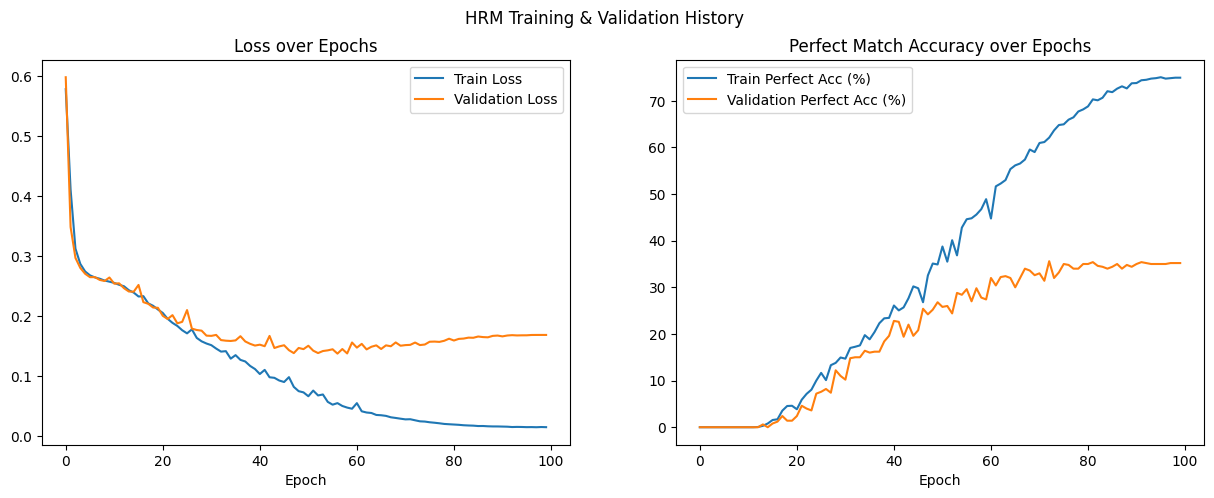


Loading best model for visualization...


Generating Mazes:   0%|          | 0/1 [00:00<?, ?it/s]

Heatmap GIF saved as hrm_best_model_reasoning.gif


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import LambdaLR
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import imageio.v2 as imageio
import io
import os
import math

# ==============================================================================
# 2. CONFIGURATION AND REPRODUCIBILITY
# ==============================================================================
class Config:
    # --- Experiment ---
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    SEED = 42
    CHECKPOINT_DIR = "./checkpoints"

    # --- Dataset ---
    MAZE_SIZE = 11
    NUM_SAMPLES = 2500
    VAL_SPLIT = 0.2  # Use 20% of data for validation

    # --- Model Architecture ---
    D_MODEL = 128
    N_HEAD = 4

    # --- HRM Specific ---
    N_CYCLES = 6
    T_STEPS = 6

    # --- Training ---
    EPOCHS = 100
    BATCH_SIZE = 64
    M_SEGMENTS = 2  # Deep supervision segments

    # --- Optimization & Regularization ---
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 0.01  # L2 regularization to prevent overfitting
    LR_WARMUP_EPOCHS = 10 # Number of epochs for linear warmup
    LR_SCHEDULE_TYPE = 'cosine' # 'cosine' or 'linear' decay after warmup

def set_seed(seed):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Initialize configuration and set seed
config = Config()
set_seed(config.SEED)
os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)
print(f"Using device: {config.DEVICE}")

# ==============================================================================
# 3. DATA GENERATION AND LOADING
# ==============================================================================
class MazeGenerator:
    def __init__(self, size):
        if size % 2 == 0: size += 1
        self.size = size
        self.maze = np.ones((size, size), dtype=np.int8)

    def _is_valid(self, r, c): return 0 <= r < self.size and 0 <= c < self.size

    def _carve_passages(self, r, c):
        self.maze[r, c] = 0
        directions = [(0, 2), (0, -2), (2, 0), (-2, 0)]
        random.shuffle(directions)
        for dr, dc in directions:
            nr, nc = r + dr, c + dc
            if self._is_valid(nr, nc) and self.maze[nr, nc] == 1:
                self.maze[r + dr // 2, c + dc // 2] = 0
                self._carve_passages(nr, nc)

    def generate(self):
        start_r, start_c = random.randrange(1, self.size, 2), random.randrange(1, self.size, 2)
        self._carve_passages(start_r, start_c)
        self.maze[1, 1] = 0
        self.maze[self.size - 2, self.size - 2] = 0
        return self.maze

    def solve(self, maze_to_solve):
        start, end = (1, 1), (self.size - 2, self.size - 2)
        q, visited = [(start, [start])], {start}
        while q:
            (r, c), path = q.pop(0)
            if (r, c) == end:
                solution = np.zeros_like(maze_to_solve)
                for pr, pc in path: solution[pr, pc] = 1
                return solution
            for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                nr, nc = r + dr, c + dc
                if self._is_valid(nr, nc) and maze_to_solve[nr, nc] == 0 and (nr, nc) not in visited:
                    visited.add((nr, nc))
                    q.append(((nr, nc), path + [(nr, nc)]))
        return np.zeros_like(maze_to_solve)

    def create_dataset(self, num_samples):
        mazes, solutions = [], []
        for _ in tqdm(range(num_samples), desc="Generating Mazes"):
            self.maze = np.ones((self.size, self.size), dtype=np.int8)
            mazes.append(self.generate())
            solutions.append(self.solve(mazes[-1]))
        return np.array(mazes), np.array(solutions)

class MazeDataset(Dataset):
    def __init__(self, mazes, solutions):
        self.mazes = torch.LongTensor(mazes)
        self.solutions = torch.FloatTensor(solutions)

    def __len__(self): return len(self.mazes)
    def __getitem__(self, idx): return self.mazes[idx].flatten(), self.solutions[idx].flatten()

# ==============================================================================
# 4. MODEL ARCHITECTURE
# ==============================================================================
class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(nn.Linear(d_model, d_model * 4), nn.GELU(), nn.Linear(d_model * 4, d_model))

    def forward(self, x):
        x = self.norm1(x + self.attn(x, x, x)[0])
        return self.norm2(x + self.ffn(x))

class HRM(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.maze_flat_dim = cfg.MAZE_SIZE**2
        self.input_embedding = nn.Embedding(2, cfg.D_MODEL)
        self.pos_embed = nn.Parameter(torch.randn(1, self.maze_flat_dim, cfg.D_MODEL))
        self.l_module = TransformerBlock(cfg.D_MODEL, cfg.N_HEAD)
        self.h_module = TransformerBlock(cfg.D_MODEL, cfg.N_HEAD)
        self.output_head = nn.Linear(cfg.D_MODEL, 1)

    def forward(self, x, initial_states):
        z_h, z_l = initial_states
        x_embedded = self.input_embedding(x) + self.pos_embed
        for _ in range(self.cfg.N_CYCLES):
            for _ in range(self.cfg.T_STEPS):
                z_l = self.l_module(z_l + z_h + x_embedded)
            z_h = self.h_module(z_h + z_l)
        return (z_h, z_l), self.output_head(z_h).squeeze(-1)

# ==============================================================================
# 5. TRAINING AND EVALUATION ENGINE
# ==============================================================================
def get_lr_scheduler(optimizer, total_epochs, warmup_epochs, schedule_type='cosine'):
    """Creates a learning rate scheduler with linear warmup."""
    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return float(current_epoch) / float(max(1, warmup_epochs))

        progress = float(current_epoch - warmup_epochs) / float(max(1, total_epochs - warmup_epochs))
        if schedule_type == 'cosine':
            return 0.5 * (1.0 + math.cos(math.pi * progress))
        else: # linear decay
            return 1.0 - progress

    return LambdaLR(optimizer, lr_lambda)

def run_epoch(model, dataloader, optimizer, criterion, is_training):
    """Runs a single epoch of training or validation."""
    model.train() if is_training else model.eval()
    total_loss, total_perfect_acc, total_pixel_acc, total_samples = 0, 0, 0, 0

    context = torch.enable_grad() if is_training else torch.no_grad()
    with context:
        for mazes, solutions in dataloader:
            mazes, solutions = mazes.to(config.DEVICE), solutions.to(config.DEVICE)
            batch_size = mazes.shape[0]

            # Initialize states
            z = (torch.zeros(batch_size, model.maze_flat_dim, config.D_MODEL, device=config.DEVICE),
                 torch.zeros(batch_size, model.maze_flat_dim, config.D_MODEL, device=config.DEVICE))

            if is_training:
                segment_loss = 0
                for _ in range(config.M_SEGMENTS):
                    optimizer.zero_grad()
                    (zh, zl), output = model(mazes, z)
                    z = (zh.detach(), zl.detach())
                    loss = criterion(output, solutions)
                    loss.backward()
                    optimizer.step()
                    segment_loss += loss.item()
                total_loss += segment_loss / config.M_SEGMENTS
            else:
                _, output = model(mazes, z)
                total_loss += criterion(output, solutions).item()

            preds = (torch.sigmoid(output) > 0.5).float()
            total_perfect_acc += (torch.all(preds == solutions, dim=1)).sum().item()
            total_pixel_acc += (preds == solutions).sum().item()
            total_samples += batch_size

    avg_loss = total_loss / len(dataloader)
    avg_perfect_acc = (total_perfect_acc / total_samples) * 100
    avg_pixel_acc = (total_pixel_acc / (total_samples * solutions.shape[1])) * 100
    return avg_loss, avg_perfect_acc, avg_pixel_acc


def train(model, train_loader, val_loader, cfg):
    """Main training loop."""
    optimizer = optim.AdamW(model.parameters(), lr=cfg.LEARNING_RATE, weight_decay=cfg.WEIGHT_DECAY)
    scheduler = get_lr_scheduler(optimizer, cfg.EPOCHS, cfg.LR_WARMUP_EPOCHS, cfg.LR_SCHEDULE_TYPE)
    criterion = nn.BCEWithLogitsLoss()

    best_val_acc = -1.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(cfg.EPOCHS):
        # Training epoch
        train_loss, train_perfect_acc, _ = run_epoch(model, train_loader, optimizer, criterion, is_training=True)

        # Validation epoch
        val_loss, val_perfect_acc, _ = run_epoch(model, val_loader, None, criterion, is_training=False)

        # Update LR scheduler
        scheduler.step()

        print(f"Epoch {epoch+1}/{cfg.EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_perfect_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_perfect_acc:.2f}% | LR: {scheduler.get_last_lr()[0]:.1e}")

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_perfect_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_perfect_acc)

        # Model Checkpointing
        if val_perfect_acc > best_val_acc:
            best_val_acc = val_perfect_acc
            checkpoint_path = os.path.join(cfg.CHECKPOINT_DIR, "best_model.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"  -> New best model saved with Val Acc: {best_val_acc:.2f}%")

    return history

# ==============================================================================
# 6. VISUALIZATION AND PLOTTING
# ==============================================================================
def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    ax2.plot(history['train_acc'], label='Train Perfect Acc (%)')
    ax2.plot(history['val_acc'], label='Validation Perfect Acc (%)')
    ax2.set_title('Perfect Match Accuracy over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    fig.suptitle(title)
    plt.show()

def visualize_reasoning_heatmap(model, maze, cfg, filename="reasoning_heatmap.gif"):
    model.eval()
    maze_flat = torch.LongTensor(maze.flatten()).unsqueeze(0).to(cfg.DEVICE)
    frames = []
    wall_overlay = np.zeros((cfg.MAZE_SIZE, cfg.MAZE_SIZE, 4), dtype=float)
    wall_overlay[maze == 1] = [0, 0, 0, 1]

    def create_frame(confidence_grid, step_num, total_steps):
        fig, ax = plt.subplots(figsize=(5, 5))
        heatmap = ax.imshow(confidence_grid, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
        ax.imshow(wall_overlay, interpolation='nearest')
        ax.set_title(f"Reasoning Step: {step_num}/{total_steps}")
        ax.axis('off')
        fig.colorbar(heatmap, ax=ax, fraction=0.046, pad=0.04)
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        buf.seek(0)
        frames.append(imageio.imread(buf))
        plt.close(fig)

    with torch.no_grad():
        total_steps = cfg.N_CYCLES * cfg.T_STEPS
        z_h = torch.zeros(1, model.maze_flat_dim, cfg.D_MODEL, device=cfg.DEVICE)
        z_l = torch.zeros(1, model.maze_flat_dim, cfg.D_MODEL, device=cfg.DEVICE)
        x_embedded = model.input_embedding(maze_flat) + model.pos_embed
        step_count = 0
        for _ in range(cfg.N_CYCLES):
            for _ in range(cfg.T_STEPS):
                z_l = model.l_module(z_l + z_h + x_embedded)
                intermediate_output = model.output_head(z_h).squeeze(-1)
                confidence_grid = torch.sigmoid(intermediate_output).cpu().numpy().reshape(cfg.MAZE_SIZE, cfg.MAZE_SIZE)
                step_count += 1
                create_frame(confidence_grid, step_count, total_steps)
            z_h = model.h_module(z_h + z_l)

    imageio.mimsave(filename, frames, duration=0.2)
    print(f"Heatmap GIF saved as {filename}")

# ==============================================================================
# 7. MAIN EXECUTION
# ==============================================================================
if __name__ == '__main__':
    # --- Data Preparation ---
    generator = MazeGenerator(config.MAZE_SIZE)
    mazes, solutions = generator.create_dataset(config.NUM_SAMPLES)
    full_dataset = MazeDataset(mazes, solutions)

    # Create train/validation split
    val_size = int(config.NUM_SAMPLES * config.VAL_SPLIT)
    train_size = config.NUM_SAMPLES - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE)

    print(f"Dataset created: {len(train_dataset)} training samples, {len(val_dataset)} validation samples.")

    # --- Model Training ---
    print("\n" + "="*30)
    print("--- Training Hierarchical Reasoning Model (HRM) ---")
    print("="*30)
    hrm_model = HRM(config).to(config.DEVICE)
    hrm_history = train(hrm_model, train_loader, val_loader, config)
    plot_history(hrm_history, "HRM Training & Validation History")

    # --- Final Evaluation and Visualization ---
    print("\nLoading best model for visualization...")
    best_model = HRM(config).to(config.DEVICE)
    best_model.load_state_dict(torch.load(os.path.join(config.CHECKPOINT_DIR, "best_model.pth")))

    # Generate a fresh maze for the final test
    test_maze, _ = generator.create_dataset(1)
    visualize_reasoning_heatmap(best_model, test_maze[0], config, filename="hrm_best_model_reasoning.gif")